<a href="https://colab.research.google.com/github/DayrisRM/VisionArtificial-M0T-DL/blob/main/VGG16_M0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving EX2_Data_v1.zip to EX2_Data_v1.zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['EX2_Data_v1.zip']), 'r')
data.extractall()

In [3]:
from tqdm import tqdm
import os
import cv2
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from PIL import Image

In [4]:
train_path = '/content/train/' 
test_path = '/content/test/'
validation_path = '/content/validation/'

In [5]:
classes = ['rot0', 'rot90','rot180','rot-90']

In [6]:
print('The training set consists of ', 
      classes[0] + ': ',
      len(os.listdir(train_path + classes[0] + '/')), ' images - ',
      classes[1] + ': ',
      len(os.listdir(train_path + classes[1] + '/')), ' images - ',
      classes[2] + ': ',
      len(os.listdir(train_path + classes[2] + '/')), ' images - ',
      classes[3] + ': ',
      len(os.listdir(train_path + classes[3] + '/')), ' images. '
      )

The training set consists of  rot0:  190  images -  rot90:  261  images -  rot180:  18  images -  rot-90:  62  images. 


In [7]:
print('The test set consists of ', 
      classes[0] + ': ',
      len(os.listdir(test_path + classes[0] + '/')), ' images - ',
      classes[1] + ': ',
      len(os.listdir(test_path + classes[1] + '/')), ' images - ',
      classes[2] + ': ',
      len(os.listdir(test_path + classes[2] + '/')), ' images - ',
      classes[3] + ': ',
      len(os.listdir(test_path + classes[3] + '/')), ' images. '
      )

The test set consists of  rot0:  79  images -  rot90:  108  images -  rot180:  7  images -  rot-90:  26  images. 




---


***Image preprocessing on dataset***


In [8]:
def preprocess_image(dir_path, imageName, img_size=(224,224)):
  img = Image.open(dir_path + imageName )  
  img = img.resize(img_size, Image.ANTIALIAS)
  pathToSave = dir_path + imageName
  img.save(pathToSave)

In [9]:
def preprocess_dataset(dir_path):
  for path in tqdm(sorted(os.listdir(dir_path))):
    if not path.startswith('.'):
      for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                  pathImage = dir_path + path + '/'                  
                  preprocess_image(pathImage , file)


In [10]:
preprocess_dataset(train_path)

100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


In [11]:
preprocess_dataset(test_path)

100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


In [12]:
preprocess_dataset(validation_path)

100%|██████████| 4/4 [00:02<00:00,  2.00it/s]




---

>  ***VGG16 model***



In [13]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from matplotlib import pyplot
from keras.callbacks import EarlyStopping

In [61]:
# define cnn model
def define_model():
  # load model
  model = VGG16(include_top=False, input_shape=(224, 224, 3))
  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False
  
  last_layer = model.get_layer('block5_pool')
  last_output = last_layer.output
  x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(4, activation='softmax')(x)
  model = tf.keras.Model(model.input, x)  

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [62]:
model = define_model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [63]:
def load_data(dir_path, img_size=(224,224)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [64]:
IMG_SIZE = (224,224)
X_val, y_val, labels = load_data(validation_path, IMG_SIZE)

100%|██████████| 4/4 [00:00<00:00, 51.86it/s]

135 images loaded from /content/validation/ directory.


In [65]:
import matplotlib.pyplot as plt
def plotHistory(history):
  N = np.arange(0, EPOCHS)
  plt.figure()
  plt.plot(N, history.history["loss"], label="train_loss")
  plt.plot(N, history.history["val_loss"], label="val_loss")
  plt.plot(N, history.history["accuracy"], label="train_acc")
  plt.plot(N, history.history["val_accuracy"], label="val_acc")
  plt.title("Training/Validation Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

In [66]:
EPOCHS = 60
def trainModel():
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(rescale=1./255)
  train_it = datagen.flow_from_directory(train_path, batch_size=64, target_size=(224, 224))
  test_it = datagen.flow_from_directory(test_path, batch_size=64, target_size=(224, 224))

  history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=EPOCHS, verbose=1)
  
  loss, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
  print('acc > %.3f' % (acc * 100.0))
  print("loss : ", loss)    
  
  plotHistory(history)

  return model
  

Found 531 images belonging to 4 classes.
Found 220 images belonging to 4 classes.
Epoch 1/60
9/9 [==============================] - 5s 450ms/step - loss: 1.1657 - accuracy: 0.5160 - val_loss: 0.8601 - val_accuracy: 0.7364
Epoch 2/60
9/9 [==============================] - 4s 416ms/step - loss: 0.8733 - accuracy: 0.6723 - val_loss: 0.7300 - val_accuracy: 0.7591
Epoch 3/60
9/9 [==============================] - 4s 419ms/step - loss: 0.7228 - accuracy: 0.7269 - val_loss: 0.6436 - val_accuracy: 0.7773
Epoch 4/60
9/9 [==============================] - 4s 421ms/step - loss: 0.5708 - accuracy: 0.8380 - val_loss: 0.5544 - val_accuracy: 0.8045
Epoch 5/60
9/9 [==============================] - 4s 422ms/step - loss: 0.4963 - accuracy: 0.8456 - val_loss: 0.4975 - val_accuracy: 0.8182
Epoch 6/60
9/9 [==============================] - 4s 425ms/step - loss: 0.4353 - accuracy: 0.8682 - val_loss: 0.4734 - val_accuracy: 0.8727
Epoch 7/60
9/9 [==============================] - 4s 429ms/step - loss: 0.4117

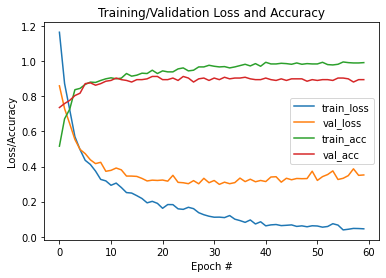

In [67]:
modelVgg = trainModel()

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

In [69]:
from sklearn.metrics import classification_report
def validateOnValSet(model):   
  predictions = model.predict(X_val, batch_size=32)
  y_pred = np.argmax(predictions, axis=1) 
  y_true = np.argmax(y_val, axis=0)   
  print("\n"+ classification_report(y_val, y_pred, target_names=classes))
  print(confusion_matrix(y_val, y_pred))
  confusion_mtx = confusion_matrix(y_val, y_pred)
  cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)
  


              precision    recall  f1-score   support

        rot0       1.00      0.81      0.90        16
       rot90       0.76      0.85      0.80        48
      rot180       0.33      0.20      0.25         5
      rot-90       0.92      0.91      0.92        66

    accuracy                           0.85       135
   macro avg       0.75      0.69      0.72       135
weighted avg       0.85      0.85      0.85       135

[[13  3  0  0]
 [ 0 41  2  5]
 [ 0  4  1  0]
 [ 0  6  0 60]]


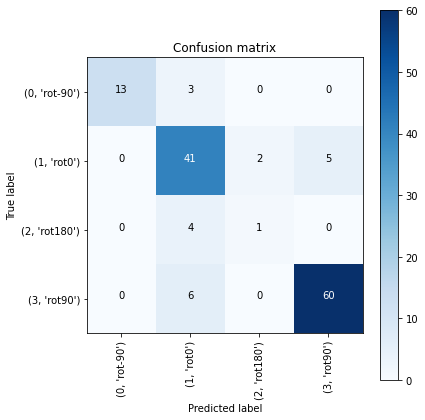

In [70]:
validateOnValSet(modelVgg)